In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from matplotlib.pyplot import imshow
import pandas as pd
import seaborn as sb
import random
random.seed(1)

In [2]:
numcat = 6 #number of categories
categories = ['AbdomenCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'HeadCT']

In [3]:
# directory = r'./Resized_MNIST/'
# train, test = [], []
# for i in range(numcat):
  #  imagearray = []
  #  for image_raw in os.listdir(directory + categories[i]):
  #      image_np = (np.array(Image.open(os.path.join(directory + categories[i], image_raw))).flatten())
  #      image = np.append(image_np, i)
  #      imagearray.append(image.astype('uint8'))
        
  #  train += imagearray[0:int(0.8*len(imagearray))]
  #  test += imagearray[int(0.8*len(imagearray)):]
# data = np.array(imagearray)
# train = np.array(train)
# test = np.array(test)

In [4]:
# np.save('Medical_train_resized.npy', train)
# np.save('Medical_test_resized.npy', test)

In [5]:
train = np.load('Medical_train_resized.npy')
test = np.load('Medical_test_resized.npy')
#shuffle train and test sets


In [6]:
np.random.shuffle(train)
np.random.shuffle(test)
#splitting into x and y - for both train and test sets
x_train, y_train = train[:, :-1], train[:, -1]
x_test, y_test = test[:, :-1], test[:, -1]

cols = x_train.shape[1]

for i in range(cols):
    train_col = x_train[:,i]
    train_mean = train_col.mean()
    train_std = train_col.std()
    x_train[:,i] = (x_train[:,i] - train_mean)/train_std
    
    test_col = x_test[:,i]
    test_mean = test_col.mean()
    test_std = test_col.std()
    x_test[:,i] = (x_test[:,i] - test_mean)/test_std

In [7]:
train_ones = np.ones((x_train.shape[0],1), dtype=x_train.dtype)
X = np.append(x_train,train_ones,axis=1)
print(X.shape) 
test_ones = np.ones((x_test.shape[0],1), dtype=x_test.dtype)
X_test = np.append(x_test,test_ones,axis=1)
print(X_test.shape)
Y = np.reshape(y_train,(y_train.shape[0],1))
print(Y.shape)
Y_test = np.reshape(y_test,(y_test.shape[0],1))
print(Y_test.shape)

(47163, 1025)
(11791, 1025)
(47163, 1)
(11791, 1)


## Conversion of output values into one-hot vectors

In [8]:
classes = 6

Y_oh = np.zeros((Y.shape[0],classes))

for i in range(Y.shape[0]):
    Y_oh[i,Y[i]] = 1
    
Y_test_oh = np.zeros((Y_test.shape[0],classes))

for i in range(Y_test.shape[0]):
    Y_test_oh[i,Y_test[i]] = 1

print(Y_oh)
print(Y)

[[0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]
[[2]
 [2]
 [1]
 ...
 [1]
 [2]
 [2]]


In [9]:
num_iter = 40
rate = 0.01

In [10]:
#subtract the maximum of each array to stabilise exponential calculation using the identity softmax(x - c) = softmax(x)

def softmax(Z):
    prob = np.zeros(Z.shape)
    
    for i in range(Z.shape[0]):
        Z_stable = Z[i] - np.amax(Z[i])
        exp = np.exp(Z_stable)
        total = np.sum(exp)
        prob[i] = exp/total
    return prob

## Cross Entropy Loss

In [25]:
#add a small positive value to make sure log does not overflow

def loss(W,X,Y):
    Z = np.matmul(X,W)
    p = softmax(Z)
    loss = 0
    
    epsilon = 1e-5
    
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if(Y[i,j] > 0):
                loss = loss - np.log(p[i,j] + epsilon)
    
    return loss/Y.shape[0]

def gradient(W,X,Y):
    Z = np.matmul(X,W)
    p = softmax(Z)
    
    grad = np.matmul(X.T,(p-Y))/X.shape[0]
    
    return grad


def sgd(W,X,Y,X_test,Y_test,rate,num_iter):
    train_loss, test_loss = [], []
    for _ in range(0, num_iter):
        grad = gradient(W,X,Y)
        W = W - rate*grad
        train_loss.append(loss(W,X,Y))
        test_loss.append(loss(W,X_test,Y_test))
        if _ == num_iter - 20:
            rate/=10
    return W, train_loss, test_loss

In [26]:
W = np.random.rand(1025,6)**0.01

print(W)

W, train_loss, test_loss = sgd(W,X,Y_oh,X_test,Y_test_oh,rate,num_iter)

print(W)

[[0.99506414 0.98659503 0.98516358 0.99548346 0.98657699 0.99724939]
 [0.99038679 0.99033293 0.99706267 0.98624501 0.98083948 0.98920498]
 [0.99225001 0.98530426 0.99981234 0.9971606  0.9985157  0.9939057 ]
 ...
 [0.99671005 0.95326044 0.98677922 0.99667074 0.99916781 0.99610502]
 [0.9989849  0.99654467 0.99255538 0.98377018 0.99747853 0.99603552]
 [0.99887807 0.99984207 0.99093138 0.99653878 0.98537393 0.99879453]]
[[0.9754811  1.0026408  0.95382255 1.38795636 0.80476578 0.821466  ]
 [0.97143322 1.06783741 0.96551816 1.42901141 0.6782843  0.82198735]
 [0.97327745 1.05049394 0.96939563 1.44800082 0.70332357 0.82245718]
 ...
 [0.98434026 0.95233097 0.96048467 1.33141479 0.84884383 0.85127877]
 [0.98764074 0.98370587 0.96476893 1.25604347 0.92524636 0.84796381]
 [1.03572115 0.97915685 1.02780107 0.96599151 0.97171836 0.98996984]]


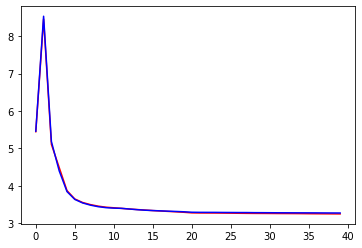

3.2515733718085174
3.275989023285407


In [27]:
plt.plot(train_loss, 'r')
plt.plot(test_loss, 'b')
plt.show()
print(train_loss[-1])
print(test_loss[-1])

## Cross Entropy Loss with L2 Regularisation

In [31]:
# W = np.random.rand(4097,6)

#add a small positive value to make sure log does not overflow

def loss_L2(W,X,Y,lam2):
    Z = np.matmul(X,W)
    # dim Z = (47163, 6)
    p = softmax(Z)
    
    #loss = -y(i)logp(i) or y product with p
    loss = 0
    
    epsilon = 1e-5
    
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if(Y[i,j] != 0):
                loss = loss - np.log(p[i,j] + epsilon)
    
    return loss/X.shape[0] + lam2*np.sum(np.multiply(W,W))

def gradient_L2(W,X,Y, lam2):
   # W_grad = np.zeros(W.shape)
    Z = np.matmul(X,W)
    p = softmax(Z)
    
    #dim p/Y = (47163,6)
    #dim X = (47163,4097)
    grad = np.matmul(X.T,(p-Y))/X.shape[0] + 2*lam2*W
    return grad

def sgd_L2(W,X,Y,X_test,Y_test,rate,num_iter,lam2):
    train_loss, test_loss = [], []
    for _ in range(0, num_iter):
        grad = gradient_L2(W,X,Y,lam2)
        W = W - rate*grad
        train_loss.append(loss_L2(W,X,Y,lam2))
        test_loss.append(loss_L2(W,X_test,Y_test,lam2))
        if _ == num_iter - 20:
            rate = rate/10
    return W, train_loss, test_loss

[[0.85715924 0.99527145 1.02716408 1.548133   0.74080918 0.79908878]
 [0.83154301 1.06624892 1.02277606 1.58418066 0.60568923 0.76389445]
 [0.85877092 1.02042128 1.02216543 1.62654059 0.61987401 0.80520838]
 ...
 [0.85833163 0.96872542 1.03014417 1.47978147 0.80024057 0.81095322]
 [0.86865506 0.97693147 1.02193733 1.4175215  0.85936611 0.79673292]
 [1.03275762 0.97008168 1.02345636 0.96379791 0.9815078  0.98991597]]


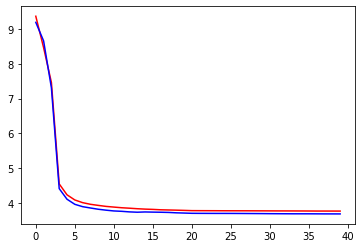

In [32]:
W_sq = np.random.rand(1025,6)**0.01

lam2 = 1e-15

W_sq, train_loss_L2, test_loss_L2 = sgd_L2(W_sq,X,Y_oh,X_test,Y_test_oh,rate,num_iter,lam2)

print(W_sq)

plt.plot(train_loss_L2, 'r')
plt.plot(test_loss_L2, 'b')
plt.show()

In [33]:
print(train_loss_L2[-1])
print(test_loss_L2[-1])

3.767937262950728
3.686650679078516


[[3.]
 [5.]
 [1.]
 ...
 [4.]
 [4.]
 [3.]]
[[3]
 [0]
 [1]
 ...
 [0]
 [4]
 [2]]


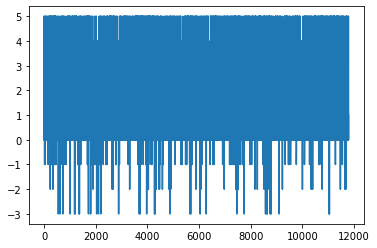

0.6342125349843101


In [58]:
Y_pred = np.zeros((Y_test.shape[0],1))
Y_test = Y_test.reshape((Y_test.shape[0],1))
one_hot_pred = np.matmul(X_test,W_sq)

correct = 0

for i in range(Y_test.shape[0]):
    maximum = -1
    for j in range(6):
        if(maximum < one_hot_pred[i,j]):
            Y_pred[i,0] = j
            maximum = one_hot_pred[i,j]
    if(Y_pred[i,0] == Y_test[i,0]):
        correct = correct + 1
    
print(Y_pred)
print(Y_test)

plt.plot(range(11791),Y_pred - Y_test)
plt.show()

print(correct/Y_test.shape[0])

In [35]:
def performance_metrics_multiclass(y_pred_test, y_test, num_class, disp_conf = True):
    '''gives the TPR, FPR, acc, precision, recall and F1 score for all classes by comparing the 2 input arrays'''
    #First we calculate the confusion matrix of size num_class*num_class
    #NOTE: Y axis of matrix will be predicted class and x axis wll be true class
    conf_mat = np.zeros((num_class, num_class))
    
    for i in range(num_class):
        for j in range(num_class):
            conf_mat[i, j] = np.logical_and(y_pred_test == i, y_test ==j).sum()
    # Calculating precision, recall, F1 Score for each class
    colnames = ['class', 'Precision', 'Recall', 'F1']
    df = pd.DataFrame(columns = colnames)
    for i in range(num_class):
        TP = conf_mat[i, i]
        FP = conf_mat[i].sum() - conf_mat[i, i]
        TN = conf_mat.sum() - conf_mat[i].sum() - conf_mat[:, i].sum() +  conf_mat[i, i]
        FN = conf_mat[:, i].sum() - conf_mat[i, i]
        P = round((TP)/(TP+FP), 5)
        R = round((TP)/(TP+FN), 5)
        F1 = round(2*P*R/(P+R), 5)
        df = df.append({'class':categories[i], 'Precision':P, 'Recall':R, 'F1':F1 }, ignore_index = True)
    macroF1 = round(df['F1'].mean(), 5)
    accuracy = round((y_pred_test==y_test).mean(), 5)
    
    # NOTE : returning the transpose of the confusion matricx to get true labels on the y axis
    conf_mat = conf_mat.T
    # NORMALIZING the confusion matrix
    conf_mat = np.around(conf_mat/(conf_mat.sum(axis = 1)), decimals = 3)
    
    
    #PLot the matrix if disp_conf = True
    if(disp_conf == True):
        ax = sb.heatmap(conf_mat, vmin = 0, vmax = 1, cmap = sb.light_palette("seagreen", as_cmap=True), xticklabels = categories, yticklabels = categories, annot = True, annot_kws={"size": 12})
    #     ax.figure.axes[-1].yaxis.label.set_size(12)
        plt.xlabel('Predicted Labels', fontsize = 14)
        plt.ylabel('True Labels', fontsize = 14)
        plt.tick_params(axis='both', labelsize=10)
        return conf_mat, df, macroF1, accuracy, plt
    
    return conf_mat, df, macroF1, accuracy

In [56]:
Y1 = Y_pred.reshape((-1,))
Y2 = Y_test.reshape((-1,))

print(Y1.shape)
print(Y2.shape)

(11791,)
(11791,)


<ipython-input-35-71481a0c51d4>:18: RuntimeWarning: invalid value encountered in double_scalars
  P = round((TP)/(TP+FP), 5)


(array([[0.024, 0.358, 0.   , 0.079, 0.282, 0.294],
        [0.   , 0.949, 0.   , 0.   , 0.016, 0.03 ],
        [0.   , 0.   , 0.   , 1.   , 0.   , 0.   ],
        [0.   , 0.02 , 0.   , 0.938, 0.044, 0.001],
        [0.   , 0.019, 0.   , 0.042, 0.928, 0.014],
        [0.   , 0.   , 0.   , 0.   , 0.   , 1.   ]]),
        class  Precision   Recall       F1
 0  AbdomenCT    1.00000  0.02400  0.04688
 1  BreastMRI    0.70539  0.94919  0.80933
 2    ChestCT        NaN  0.00000      NaN
 3        CXR    0.45567  0.93800  0.61337
 4       Hand    0.73089  0.92750  0.81754
 5     HeadCT    0.74645  0.99950  0.85464,
 0.62835,
 0.63421,
 <module 'matplotlib.pyplot' from '/root/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>)

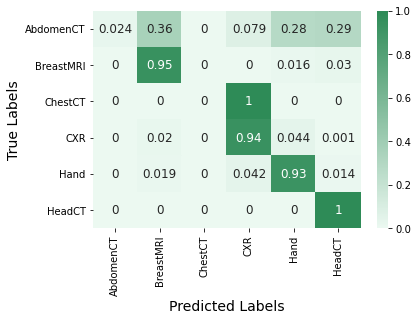

In [57]:
performance_metrics_multiclass(Y1,Y2,6)